In [1]:
from utils.loader import Loader
from utils.plot_res import plotpkl
import matplotlib.pyplot as plt
#import plotly.express as px
#import plotly.graph_objects as go
#import plotly.figure_factory as ff
import torch
import numpy as np
import pandas as pd
import pickle

## Load Pretrained Models

In [2]:
folder = '2024-08-22-102315'
with open(f'checkpoint/{folder}/hyperparam.pkl', 'rb') as f:
    args = pickle.load(f)  
device = torch.device('cuda:0')
loader = Loader(args, device)
model = loader.load_model(folder=folder, model_name='best_v')
# plotpkl(f'checkpoint/{folder}/loss_log_dict.pkl', 'Experiment')

/netpool/homes/wangyo/Projects/LQ2/src/utils/loader.py:80: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)
/netpool/homes/wangyo/.conda/envs/pyt

## Generate Grid Data and Predict their Scores

In [3]:
width_ranges = list(range(300,1200,100))
band_ranges = [b/100 for b in list(range(30,101,5))]
nbars = list(range(5, 31))
width_grid = loader.minmax(np.array(width_ranges), 'width')
bandwidth_grid = loader.minmax(np.array(band_ranges), 'bandwidth')
b_g, w_g = np.meshgrid(bandwidth_grid, width_grid)
paras = list(zip(b_g.flatten(), w_g.flatten()))
origindim = {
    'nbar': nbars,
    'bandwidth': band_ranges,
    'width': width_ranges,
    'aspectRatio': [x/300 for x in width_ranges]
}
param_list = []
for nbar in nbars:
    nnbar = loader.minmax(nbar, 'nbar')
    param_list += [torch.FloatTensor([x[1], nnbar, x[0]]).to(device) for x in paras]
dataset = torch.stack(param_list)

In [3]:
names = list(range(dataset.shape[0]))
results = model.assess(dataset, names) # make prediction
record = pd.DataFrame()                # organize result
record['score'] = [res[1] for res in results]
record['idx'] = names
record['nbar'] = dataset[:,1].detach().cpu()
record['width'] = dataset[:,0].detach().cpu()
record['bandwidth'] = dataset[:,2].detach().cpu()
record = loader.batch_denormalize(record)
# record = record.astype({'width': 'int32', 'nbar': 'int32'})
record['aspectRatio'] = record['width'].apply(lambda x: x / 300)
record.corr()

,score,idx,nbar,width,bandwidth,aspectRatio
score,1.000000,-0.244494,-2.523995e-01,1.580612e-01,3.933799e-01,1.580612e-01
idx,-0.244494,1.000000,9.992601e-01,3.822339e-02,4.263997e-03,3.822339e-02
nbar,-0.252400,0.999260,1.000000e+00,2.595847e-16,2.066432e-15,7.046797e-16
width,0.158061,0.038223,2.595847e-16,1.000000e+00,5.139118e-17,1.000000e+00
bandwidth,0.393380,0.004264,2.066432e-15,5.139118e-17,1.000000e+00,5.529043e-17
aspectRatio,0.158061,0.038223,7.046797e-16,1.000000e+00,5.529043e-17,1.000000e+00


<Axes: >

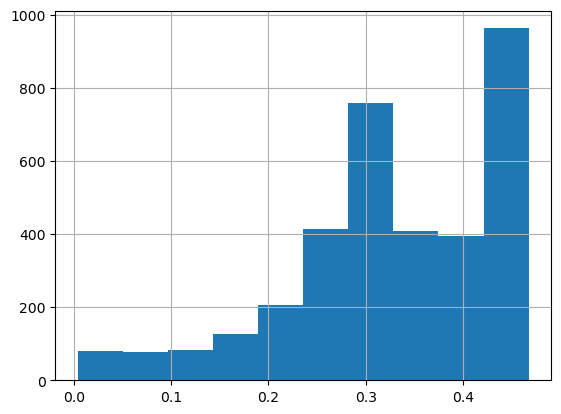

In [4]:
record['score'].hist()

In [5]:
def scatter(df, xaxis='nbar', yaxis='score', color=None):
    data = df
    if color is not None:
        data[color] = df[color].astype('str')
    px.scatter(data, x=xaxis, y=yaxis, color=color, marginal_y="box").show()
                
def heatmap(record, xaxis='nbar', yaxis='width', aggr='mean'):
    xx = origindim[xaxis]
    yy = origindim[yaxis]
    df = record
    eps = 0.01
    if aggr is 'max':
        data = [[df[(abs(df[xaxis]-x)<eps) & (abs(df[yaxis]-y)<eps)]['score'].max() for x in xx] for y in yy]
    elif aggr is 'mean':
        data = [[df[(abs(df[xaxis]-x)<eps) & (abs(df[yaxis]-y)<eps)]['score'].mean() for x in xx] for y in yy]
    elif aggr is 'min':
        data = [[df[(abs(df[xaxis]-x)<eps) & (abs(df[yaxis]-y)<eps)]['score'].min() for x in xx] for y in yy]
    else:
        return
    fig = go.Figure(data=go.Heatmap(
        z=data,
        x=xx,
        y=yy,
        colorscale='Emrld'))
    fig.update_layout(xaxis_title=xaxis, yaxis_title=yaxis)  
    fig.show()
    return fig    

<>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:16: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:16: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_626589/2686349500.py:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if aggr is 'max':
/tmp/ipykernel_626589/2686349500.py:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif aggr is 'mean':
/tmp/ipykernel_626589/2686349500.py:16: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif aggr is 'min':


In [6]:
fig=heatmap(record[record.nbar == 20], xaxis='aspectRatio', yaxis='bandwidth', aggr='max')

/tmp/ipykernel_626589/2686349500.py:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if aggr is 'max':
/tmp/ipykernel_626589/2686349500.py:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif aggr is 'mean':
/tmp/ipykernel_626589/2686349500.py:16: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif aggr is 'min':
/tmp/ipykernel_626589/2686349500.py:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if aggr is 'max':
/tmp/ipykernel_626589/2686349500.py:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif aggr is 'mean':
/tmp/ipykernel_626589/2686349500.py:16: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif aggr is 'min':
/tmp/ipykernel_626589/2686349500.py:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if aggr is 'max':
/tmp/ipykernel_626589/2686349500.py:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif aggr is 'mean':
/tmp/ipykernel_626589/2686349500.py:16: SyntaxWarning: "is" with a 

NameError: name 'go' is not defined

In [7]:
for nbar in list(range(5,35,5)):
#     heatmap(record, xaxis='width', yaxis='bandwidth', fix='nbar', fixv=15)
    heatmap(record[record.nbar == nbar], xaxis='width', yaxis='bandwidth', aggr='mean')

NameError: name 'go' is not defined

## Predict LQ2 score

In [14]:
param_list = []

for nbar in nbars:
    nnbar = loader.minmax(nbar, 'nbar')
    param_list += [torch.FloatTensor([x[1], nnbar, x[0]]).to(device) for x in paras]
dataset = torch.stack(param_list)
print(param_list)

[tensor([0., 0., 0.], device='cuda:0'), tensor([0.0000, 0.0000, 0.0714], device='cuda:0'), tensor([0.0000, 0.0000, 0.1429], device='cuda:0'), tensor([0.0000, 0.0000, 0.2143], device='cuda:0'), tensor([0.0000, 0.0000, 0.2857], device='cuda:0'), tensor([0.0000, 0.0000, 0.3571], device='cuda:0'), tensor([0.0000, 0.0000, 0.4286], device='cuda:0'), tensor([0.0000, 0.0000, 0.5000], device='cuda:0'), tensor([0.0000, 0.0000, 0.5714], device='cuda:0'), tensor([0.0000, 0.0000, 0.6429], device='cuda:0'), tensor([0.0000, 0.0000, 0.7143], device='cuda:0'), tensor([0.0000, 0.0000, 0.7857], device='cuda:0'), tensor([0.0000, 0.0000, 0.8571], device='cuda:0'), tensor([0.0000, 0.0000, 0.9286], device='cuda:0'), tensor([0., 0., 1.], device='cuda:0'), tensor([0.2000, 0.0000, 0.0000], device='cuda:0'), tensor([0.2000, 0.0000, 0.0714], device='cuda:0'), tensor([0.2000, 0.0000, 0.1429], device='cuda:0'), tensor([0.2000, 0.0000, 0.2143], device='cuda:0'), tensor([0.2000, 0.0000, 0.2857], device='cuda:0'), ten

In [14]:
param_list = []
def truncate(inpu):
    if inpu < 0:
        return 0
    if inpu > 1:
        return 1
    return inpu

df = pd.read_csv('/netpool/homes/wangyo/Projects/vega_editor_backend/evaluation/param_lq2.csv')
len(df['nbar'])
for id in range(len(df['nbar'])):
    nnbar = truncate(loader.minmax(df['nbar'][id], 'nbar'))
    nbandwidth = truncate(loader.minmax(df['bandwidth'][id], 'bandwidth'))
    nwidth = truncate(loader.minmax(df['width'][id], 'width'))
    param_list += [torch.FloatTensor([nwidth, nnbar, nbandwidth]).to(device)]

dataset = torch.stack(param_list)

In [15]:
names = list(range(dataset.shape[0]))
results = model.assess(dataset, names) # make prediction

In [16]:
lq2 = [ res[1] for res in results]
df['LQ2'] = lq2
df

,filename,nbar,bandwidth,width,LQ2
0,86398352001580,4,54.945393,464.532510,0.390510
1,17368637001831,2,122.752958,498.144975,0.330706
2,49302962006837,4,72.297468,421.456926,0.437147
3,11830365006450,5,61.394968,443.457732,0.427064
4,94483094006737,7,185.669597,541.459409,0.332207
...,...,...,...,...,...
528,78151143005492,4,128.733467,616.852340,0.281238
529,14354115005935,3,64.390683,225.818004,0.446104
530,12784129003060,5,109.965235,799.847713,0.220236
531,11128,8,143.253493,548.514913,0.347931


In [17]:
df.to_csv('/netpool/homes/wangyo/Projects/vega_editor_backend/evaluation/param_lq2.csv', index=False)